## Import relevant packages

In [4]:
import pandas as pd 
import requests 
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from datetime import datetime
from dateutil import relativedelta

### Scraping data from motorist.sg

In [2]:
motorist = []

for page in range(50):
  try:
    domain = 'https://www.motorist.sg/used-cars/used-cars?'
    page_num = 'page=' + str(page)
    url = domain + page_num
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')

    # getting all the listings on the page
    listings = soup.find_all('div', class_ = 'col-12 press-div mb-0')

    for listing in listings:
      model = listing.find_all('p', class_ = 'font-weight-bold line-height-1-2 mb-0')[0].text.strip().title()

      brand = model.split()[0]

      price = listing.find_all('span', class_ = 'text-green')[0].text.strip()

      depreciation = listing.find_all('div', class_ = 'col-2 font-14 line-height-1-2')[0].text.strip()

      registration_details = listing.find_all('div', class_ = 'col-7 font-14 line-height-1-2')[0].text.strip()
      registration_date = registration_details.split('(')[0].strip()
      coe_remaining = registration_details.split('(')[1].strip()


      coe_remaining = listing.find_all('span', class_ = 'font-12')[0].text.strip()

      mileage = listing.find_all('div', class_ = 'col-5 font-14 line-height-1-2')[0].text.strip()

      row = {
          'source': 'motorist.sg',
          'model': model,
          'brand': brand,
          'price': price,
          'depreciation': depreciation,
          'registration_date': registration_date,
          'coe_remaining': coe_remaining,
          'mileage': mileage
      }

      motorist.append(row)

  except IndexError:
    break

In [3]:
# creating a df using the scraped data

df = pd.DataFrame(motorist)
df

,source,model,brand,price,depreciation,registration_date,coe_remaining,mileage
0,motorist.sg,Mercedes Benz G350 Premium Amg Line Diesel Auto,Mercedes,"$568,800","$55,082/yr",19/05/2021,(8 yrs 8 mths COE left),"18,000 km"
1,motorist.sg,Audi Q5 2.0 Tfsi Quattro,Audi,"$100,800","$12,489/yr",21/04/2011,(8 yrs COE left),"88,000 km"
2,motorist.sg,Toyota Dyna 3.0 Auto,Toyota,"$85,800","$11,062/yr",08/06/2020,(7 yrs 9 mths COE left),-
3,motorist.sg,Toyota Dyna 150 5Mt,Toyota,"$78,800","$12,131/yr",05/03/2019,(6 yrs 5 mths COE left),-
4,motorist.sg,Nissan Pickup 2.6 M,Nissan,"$23,800","$9,222/yr",06/04/2005,(2 yrs 6 mths COE left),-
...,...,...,...,...,...,...,...,...
1605,motorist.sg,Audi A4 1.4 Tfsi S Tronic,Audi,"$68,458","$14,966/yr",10/05/2016,(3 yrs 8 mths COE left),"71,000 km"
1606,motorist.sg,Volvo Xc40 T4 R-Design,Volvo,"$132,604","$16,903/yr",31/07/2019,(6 yrs 10 mths COE left),"43,000 km"
1607,motorist.sg,Mitsubishi Lancer 1.6 M,Mitsubishi,"$15,888","$11,692/yr",16/01/2009,(1 yr 4 mths COE left),"300,000 km"
1608,motorist.sg,Suzuki Sx4 S-Cross 1.6 Cvt 4Wd S/R,Suzuki,"$48,000","$11,646/yr",24/12/2015,(3 yrs 3 mths COE left),"75,000 km"


In [ ]:
# cleaning the df

# removing dollar sign and comma in price column
for item in ['$', ',']:
  df['price'] = df['price'].str.replace(item, '', regex = False)
  df['price'] = df['price'].str.strip() # removing any whitespaces


# removing dollar sign and /yr in depreciation column
for item in ['$', '/yr', ',']:
  df['depreciation'] = df['depreciation'].str.replace(item, '', regex = False)
  df['depreciation'] = df['depreciation'].str.strip() # removing any whitespaces

# removing brackets and COE left from the column
for item in ['(', ')', 'yrs', 'yr', 'mth', 'mths', 'COE', 'left', 's']:
  df['coe_remaining'] = df['coe_remaining'].str.replace(item, '', regex = False)
  df['coe_remaining'] = df['coe_remaining'].str.strip() # removing any whitespaces

# spliting coe_remaining into years and months then coverting to months
df[['year', 'months']] = df['coe_remaining'].str.split(' ', 1, expand=True) 

df = df.dropna() # dropping all NAs

df['months'] = df['months'].astype(int) # changing the dtype
df['year'] = df['year'].astype(int) # changing the dtype

df['coe_remaining'] = df['year'] * 12 + df['months']

df.drop(['year', 'months'], axis=1, inplace=True)

df.rename(columns = {'coe_remaining': 'coe_remaining_mths'}, inplace = True)

# removing 'km' and commas from mileage
for item in ['km', ',']:
  df['mileage'] = df['mileage'].str.replace(item, '', regex = False)
  df['mileage'] = df['mileage'].str.strip() # removing any whitespaces

# changing registration date to datetime object
df['registration_date']= pd.to_datetime(df['registration_date'], format = '%d/%m/%Y')

In [6]:
df.to_clipboard()

### Scarping data from carbuyer.com.sg

In [7]:
url = "https://marketplace.carbuyer.com.sg/used-cars/search/?page=1"
res = requests.get(url)
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url)
#stages = driver.find_elements_by_class_name('card-body')
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.close()
#soup = BeautifulSoup(res.content, "html.parser")

# Getting a list of all the page listings
listings = soup.find_all("div", class_="card-body")

<ipython-input-7-c24cfcf299df>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [ ]:
car_data = []

for page in range(1, 200):
  domain = "https://marketplace.carbuyer.com.sg/used-cars/search/?page="
  url = domain + str(page)
  res = requests.get(url)
  driver = webdriver.Chrome(ChromeDriverManager().install())
  driver.get(url)
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  listings = soup.find_all("div", class_="card-body")
  # Iterate through listings and extract relevant details for each listing
  for listing in listings:
    # Extracting name
    name = listing.find_all("h4")[0].text.strip()

    # Extracting price
    price = listing.find_all("div", class_="price")[0].text.strip()
    instalment = listing.find_all("div", class_="price")[0].text.strip()

    mileage = listing.find_all("div", class_="spec-item")[1].text.strip()
    depreciation = listing.find_all("div", class_="car-depr")[0].text.strip() 
    purchase_date = listing.find_all("div", class_="spec-item reg-date")[0].text.strip()
    #expiration = listing.find_all("span", style_="color:#A1A1A1;margin-left:5px")[0].text.strip()



    row = {
        "car_name": name,
        "price": price,
        "instalment": instalment,
        "mileage": mileage,
        "depreciation": depreciation,
        "purchase_date": purchase_date,
        #"expiration": expiration
    }

    car_data.append(row)

In [43]:
df = pd.DataFrame(car_data)

In [44]:
df

,car_name,price,instalment,mileage,depreciation,purchase_date
0,Honda Civic 1.8 VTi-S (A),"$29,888$752/mo$14,205/yr depr.","$29,888$752/mo$14,205/yr depr.",N/A,"$14,205/yr depr.",14/10/2009(2 yrs 1 mths left)
1,TOYOTA DYNA 3.0 MANUAL,"$62,800$733/mo$12,895/yr depr.","$62,800$733/mo$12,895/yr depr.","110,789km","$12,895/yr depr.",28/06/2017(4 yrs 9 mths left)
2,Nissan Qashqai 1.2 DIG-T Premium (A),"$58,800$788/mo$12,567/yr depr.","$58,800$788/mo$12,567/yr depr.",N/A,"$12,567/yr depr.",26/10/2016(4 yrs 1 mths left)
3,TOYOTA HIACE MANUAL,"$39,800$458/mo$8,120/yr depr.","$39,800$458/mo$8,120/yr depr.","180,255km","$8,120/yr depr.",31/08/2007(4 yrs 10 mths left)
4,ISUZU NPR75UH5A,"$55,800$762/mo$13,718/yr depr.","$55,800$762/mo$13,718/yr depr.","110,000km","$13,718/yr depr.",07/09/2016(4 yrs 0 mths left)
...,...,...,...,...,...,...
1533,SEAT Ateca 1.4A TSI Style,"$113,800$943/mo$13,707/yr depr.","$113,800$943/mo$13,707/yr depr.","18,000km","$13,707/yr depr.",14/11/2019(7 yrs 2 mths left)
1534,Mercedes-Benz C-Class C180 CGI (New 10-yr COE),"$59,800$496/mo$4,844/yr depr.","$59,800$496/mo$4,844/yr depr.","50,000km","$4,844/yr depr.",22/10/2012(9 yrs 2 mths left)
1535,Mercedes-Benz C-Class C200 Sport Sunroof,"$136,800$1,459/mo$21,548/yr depr.","$136,800$1,459/mo$21,548/yr depr.","53,008km","$21,548/yr depr.",28/12/2017(5 yrs 3 mths left)
1536,Mercedes-Benz C-Class C63 AMG Premium Plus,"$388,888$3,222/mo$37,696/yr depr.","$388,888$3,222/mo$37,696/yr depr.","18,000km","$37,696/yr depr.",23/08/2021(8 yrs 11 mths left)


In [ ]:
# cleaning the df

df[['purchase_date', 'remaining']] = df['purchase_date'].str.split('(', 1, expand=True)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['remaining'] = df['remaining'].fillna("left)")

for i in range(df.shape[0]):
    df['price'][i] = df['price'].str.split("$")[i][1]
    df['instalment'][i]=df['instalment'].str.split("$")[i][2]
    df['instalment'][i]=df['instalment'].str.split("/")[i][0]
    df['mileage'][i] = df['mileage'][i].replace("km","")
    df['depreciation'][i] = df['depreciation'].str.split("/")[i][0]
    df['depreciation'][i] = df['depreciation'].str.split("$")[i][1]
    df['remaining'][i] = df['remaining'][i].replace("left)","")
    df['price'][i] = df['price'][i].replace(",","")
    df['mileage'][i] = df['mileage'][i].replace(",","")
    df['depreciation'][i] = df['depreciation'][i].replace(",","")
    df['instalment'][i] = df['instalment'][i].replace(",","")
    
# Cleaning remaining column
df[["remaining_years", "year", "remaining_months", "mths"," "]] = df['remaining'].str.split(' ', expand=True)
df = df.drop('year', axis=1)
df = df.drop('mths', axis=1)

In [46]:
# Dropping empty and NA cells
df.drop(df[df['remaining'] == ""].index, inplace = True)
df.drop(df[df['mileage'] == "N/A"].index, inplace = True)

In [47]:
# Changing column data type
df['price']= pd.to_numeric(df['price'])
df['remaining_years']= pd.to_numeric(df['remaining_years'])
df['mileage']= pd.to_numeric(df['mileage'])

#### Scraping Data from GoWheeler

In [8]:
cars_data = []

for i in range(1,4):
    url = "https://www.gowheeler.com.sg/used-cars/page/" 
    res = requests.get(url + str(i) + '/')
    soup = BeautifulSoup(res.content, "html.parser")
    listings = soup.find_all("div", class_="listing-car-item-meta")
    
    for listing in listings:
      # Extracting title
      title = listing.find_all("div", class_="car-title")[0].text.strip() # Fill in the element and class 
      brand = title.split()[0]

      # Extracting price
      price = listing.find_all("div", class_="normal-price")[0].text.strip() # Fill in the element and class 

      # Extracting mileage
      mil = listing.find_all("ul", class_="")[0].text.strip() # Fill in the element and class
      mileage = mil.split("\n")[1].strip()
      date = mil.split("\n")[0].strip()

      row = {
          "Model": title,
          "Price": price,
          "Mileage": mileage,
          "Brand": brand,
          "Registered Date": date,
          "Source": "GOwheeler"
      }

      cars_data.append(row)

In [9]:
# Saving into a dataframe
df = pd.DataFrame(cars_data)

In [ ]:
# cleaning the df

df['Price'] = df['Price'].str.replace('$', '') #remove '$'
df['Price'] = df['Price'].str.replace(',', '') #remove comma
df['Price'] = pd.to_numeric(df['Price'])

df['Mileage'] = df['Mileage'].str.replace(',', '') #remove comma
df['Mileage'] = df['Mileage'].str.replace(' km', '') #remove km
df['Mileage'] = pd.to_numeric(df['Mileage'])

df['Registered Date'] = df['Registered Date'].str.replace('Reg. ', '') 

#### Scraping data from Carro

In [27]:
carro = []

brands = ['Alpina', 'Audi', 'Bentley', 'BMW', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'Land rover', 'Lexus', 'Mazda', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel', 'Perodua', 'Porsche', 'Seat', 'Skoda', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

for brand in brands:
    url = "https://carro.sg/?query=" + brand

    res = requests.get(url)
    soup = BeautifulSoup(res.content, "html.parser")
    
    listings = soup.find_all("div", class_ = "HitsV2__StyledColV2-i166w2-4 dsjgqd")

    for listing in listings:

        try:

            price = listing.find_all("span", class_ = "carPriceText")[0].text.strip() 
            instalment = listing.find_all("div", class_ = "extra-price-info")[0].text.strip().split(" ")[1]

            model = listing.find_all("div", class_ = "hit-title")[0].text.strip()

            car_details = listing.find_all("div", class_ = "HitCard__StyledCarDetailWrapper-sc-17nv8l6-22 dYrYIT")
            mileage = car_details[0].text.strip()
            num_of_owners = car_details[1].text.strip()
            depreciation = car_details[2].text.strip()
            reg_date = car_details[3].text.strip().split("(")[0]
            coe_left = car_details[3].text.strip().split("(")[1][:-1]
        
            entry = {
                "model": model,

                "price": price,
                "instalment": instalment,
                
                "mileage": mileage,
                "num_of_owners": num_of_owners,
                "depreciation" : depreciation,
                "reg_date": reg_date,
                "coe_left": coe_left
            }
    
            carro.append(entry)

        except IndexError:
            break

In [38]:
# saving into a dataframe
df = pd.DataFrame(carro)
df

,model,price,instalment,mileage,num_of_owners,depreciation,reg_date,coe_left
0,BMW ALPINA B3 Bi-Turbo,"$183,888","$2,380/month","84,513 km",2 Owners,"$29,640/yr",11 Nov 16,4yrs 2mths left
1,Audi A4 1.4A TFSI S-tronic,"$93,888","$1,343/month","62,367 km",2 Owners,"$18,140/yr",09 Feb 17,4yrs 5mths left
2,Audi A3 Sedan 1.4A TFSI Ambiente,"$64,888","$1,207/month","63,480 km",2 Owners,"$16,110/yr",25 Jan 16,3yrs 4mths left
3,Audi A4 1.4A TFSI S-tronic,"$108,888","$1,349/month","26,800 km",1 Owner,"$18,290/yr",15 Nov 17,5yrs 2mths left
4,Audi A6 1.8A TFSI Ultra,"$113,888","$1,477/month","77,285 km",1 Owner,"$18,510/yr",28 Aug 17,4yrs 11mths left
...,...,...,...,...,...,...,...,...
376,Volvo XC40 T4 Momentum,"$178,088","$1,698/month","2,419 km",1 Owner,"$23,680/yr",25 Oct 18,6yrs 1mths left
377,Volvo XC40 T5 Momentum,"$117,000","$1,179/month","50,438 km",1 Owner,"$15,750/yr",25 Apr 18,5yrs 7mths left
378,Volvo S60 T4,"$33,888",$0/month,"140,000 km",2 Owners,Paper Value : $0,05 Apr 12,5mths left
379,Volvo S60 D2,"$49,888",$0/month,"100,000 km",2 Owners,$0/yr,30 Sep 14,2yrs left


In [ ]:
# removing '$' and ',' and converting to int
df['price'] = df['price'].str.replace(r'[$,]', '', regex = True).astype(int)

# removing '$', '/' and 'month' and converting to int
df['instalment'] = df['instalment'].str.replace(r'[$,/month]', '', regex = True).astype(int)

# removing '$', ',' and 'km' and converting to int
df['mileage'] = df['mileage'].str.replace(r'[,km]', '', regex = True).astype(int)

# removing 'Owner' and 'Owners' and converting to int
df['num_of_owners'] = df['num_of_owners'].str.replace(r'[Owners]', '', regex = True).astype(int)

# removing all non-numeric and converting to int
df['depreciation'] = df['depreciation'].str.replace('[^0-9]', '', regex = True).astype(int)

# convert coe_left from years and months to months
df['coe_left_yrs'] = df['coe_left'].str.extract(r'(\wyrs)').replace('[yrs]', '', regex = True).astype(int)
df['coe_left_mths'] = df['coe_left'].str.extract(r'(\w+mths)').replace('[mths]', '', regex = True).astype(int)
df['coe_left_yrs'] = df['coe_left_yrs'].fillna(0)
df['coe_left_mths'] = df['coe_left_mths'].fillna(0)
df['coe_months'] = df['coe_left_yrs'] * 12 + df['coe_left_mths']

### Combining the dataset together

#### Carro Data

In [43]:
# Importing carro data
data1 = pd.read_csv('carro.csv')


In [44]:
data1['brand'] = 1

for row in range(len(data1)):
    value = data1.loc[row, 'model']
    brand = value.split()[0]
    data1.loc[row, 'brand'] = brand

data1 = data1[['source', 'model', 'brand', 'price', 'depreciation', 'reg_date', 'coe_months', 'mileage']]
data1['reg_date'] = pd.to_datetime(data1['reg_date'])

#### Carbuyer Data

In [48]:
# Importing carbuyer data
data2 = pd.read_csv('carbuyer.csv')

In [49]:
data2['brand'] = 1

for row in range(len(data2)):
    value = data2.loc[row, 'car_name']
    brand = value.split()[0]
    data2.loc[row, 'brand'] = brand

data2['coe_months'] = (data2['remaining_years'].astype(int)) * 12 + (data2['remaining_months'].astype(int))

data2 = data2[['source', 'car_name', 'brand', 'price', 'depreciation', 'purchase_date', 'coe_months', 'mileage']]
data2['purchase_date'] = pd.to_datetime(data2['purchase_date'])

#### GoWheeler Data

In [53]:
# Importing GoWheeler Data

data3 = pd.read_csv('GOwheeler.csv')

In [54]:
# Depreciation data was empty and sources online indicate vehicles experience an average of 15% depreciation Year-On-Year
# Link to source: https://www.lendingtree.com/auto/how-much-do-new-cars-depreciate/#:~:text=A%20car%20can%20lose%20up,year%20after%20the%20first%20year

data3['depreciation'] = 0.15 * (data3['Price'].astype(int))
data3['depreciation'] = data3['depreciation'].astype(int)


data3 = data3[['Source', 'Model', 'Brand', 'Price', 'depreciation', 'Registered Date', 'Mileage']]

In [55]:
# Changing to registered date to datetime object
data3['Registered Date'] = pd.to_datetime(data3['Registered Date'])

### Importing combined data

In [5]:
data = pd.read_csv('used_cars_1.csv')

In [6]:
# Renaming the brands

data['brand'] = data['brand'].str.title()

idx_bmw = data[(data['brand'] == 'Bmw') | (data['brand'] == 'B.M.W.')].index.tolist()
idx_merc = data[(data['brand'] == 'Mercedes') | (data['brand'] == 'Mercedes-Benz')].index.tolist()
idx_aston = data[(data['brand'] == 'Aston')].index.tolist()
idx_mg = data[(data['brand'] == 'Mg')].index.tolist()
idx_land = data[(data['brand'] == 'Land')].index.tolist()
idx_rolls = data[(data['brand'] == 'Rolls')].index.tolist()
idx_byd = data[(data['brand'] == 'Byd')].index.tolist()

for idx in idx_bmw:
    data.loc[idx, 'brand'] = 'BMW'

for idx in idx_merc:
    data.loc[idx, 'brand'] = 'Mercedes'

for idx in idx_aston:
    data.loc[idx, 'brand'] = 'Aston Martin'

for idx in idx_mg:
    data.loc[idx, 'brand'] = 'MG'

for idx in idx_land:
    data.loc[idx, 'brand'] = 'Land Rover'

for idx in idx_rolls:
    data.loc[idx, 'brand'] = 'Rolls Royce'

for idx in idx_byd:
    data.loc[idx, 'brand'] = 'BYD'


#### Qn: How does the Registration Year of the vehicle affect its Price?

In [7]:
# to find avg price of each brand per year
data['registration_date'] = pd.to_datetime(data['registration_date'])
data['year'] = data['registration_date'].dt.year
avg = data.groupby(['year','brand'], as_index=False)['price'].mean().round(2)
mean_price_brand = pd.DataFrame(avg).sort_values(by='year', ascending=False)
mean_price_brand = mean_price_brand.reset_index(drop=True)
mean_price_brand.head()


,year,brand,price
0,2022,Toyota,104296.56
1,2022,Kia,129800.00
2,2022,Audi,699800.00
3,2022,BMW,276665.43
4,2022,Citroen,105800.00


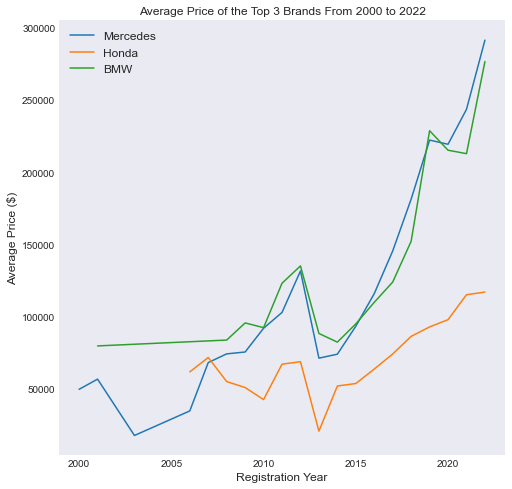

In [26]:
# top 3 brands
mercedes = mean_price_brand.loc[(mean_price_brand['brand'] == 'Mercedes') & (mean_price_brand['year'] >= 2000)]
honda = mean_price_brand.loc[(mean_price_brand['brand'] == 'Honda') & (mean_price_brand['year'] >= 2000)]
Bmw = mean_price_brand.loc[(mean_price_brand['brand'] == 'BMW') & (mean_price_brand['year'] >=- 2000)]

Mercedes = plt.plot(mercedes['year'], mercedes['price']) 
Honda = plt.plot(honda['year'], honda['price']) 
BMW = plt.plot(Bmw['year'], Bmw['price']) 

plt.style.use('seaborn-dark')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlabel('Registration Year', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Price of the Top 3 Brands From 2000 to 2022', fontsize=12)
plt.legend(['Mercedes', 'Honda', 'BMW'], prop={'size': 12})
plt.show()

#### Qn: How does the number of years remaining for COE of the used vehicle affect its Price?

In [52]:
# Finding the number of years left
data['coe_remaining_years'] = data['coe_remaining_mths'] // 12

# Changing data type
data['price']= pd.to_numeric(data['price'])

Text(0.5, 1.0, 'Boxplot of Remaining Years of COE Against Price')

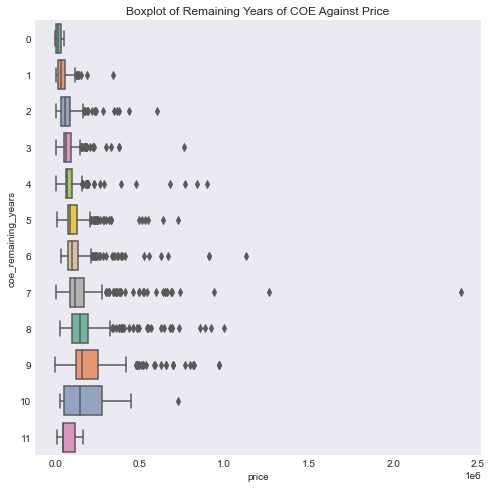

In [54]:
# Plotting a boxplot of number of years remaining COE vs price
plt.figure(figsize=(8,8))
sns.boxplot(y="coe_remaining_years", x="price", data=data, orient="h", palette="Set2").set_title('Boxplot of Remaining Years of COE Against Price')

#### Qn: How does the Depreciation of the used vehicle affects is Price?

In [40]:
# Finding depreciation per month
data['depreciation_per_mth'] = data['depreciation'] / data['coe_remaining_mths']

In [41]:
quantile = data.describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile['IQR'] =  quantile['75%'] - quantile['25%']

iqr_price = quantile['IQR']['price']
q1_price = quantile['25%']['price']
q3_price = quantile['75%']['price']
left_bound_price = max(q1_price - 1.50 * iqr_price, 0)  # price cannot be zero
right_bound_price = q3_price + 1.50 * iqr_price

iqr_depreciation_per_mth = quantile['IQR']['depreciation_per_mth']
q1_depreciation_per_mth = quantile['25%']['depreciation_per_mth']
q3_depreciation_per_mth = quantile['75%']['depreciation_per_mth']
left_bound_depreciation_per_mth = max(q1_depreciation_per_mth - 1.50 * iqr_depreciation_per_mth, 0)  # price cannot be zero
right_bound_depreciation_per_mth = q3_depreciation_per_mth + 1.50 * iqr_depreciation_per_mth

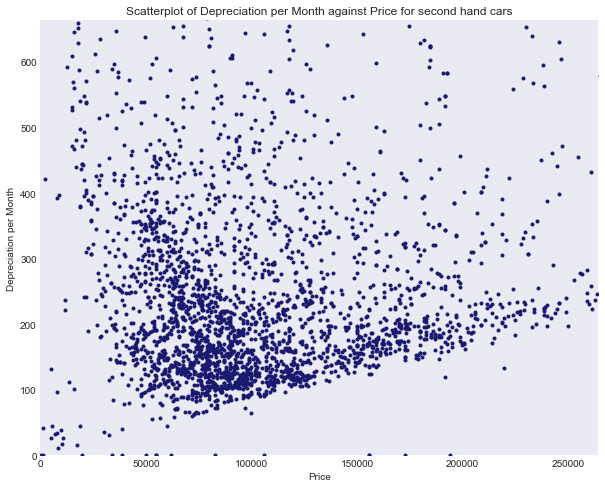

In [42]:
plt.figure(figsize=(10,8))

plt.scatter(x = data['price'], y = data['depreciation_per_mth'], c = "midnightblue", marker = ".", alpha = 1.0)
plt.xlabel("Price")
plt.ylabel("Depreciation per Month")
plt.xlim(left_bound_price, right_bound_price)
plt.ylim(left_bound_depreciation_per_mth, right_bound_depreciation_per_mth)
plt.title("Scatterplot of Depreciation per Month against Price for second hand cars")
plt.ticklabel_format(style = 'plain')

plt.show()

#### Qn: How does Mileage affect Price?

<AxesSubplot:xlabel='mileage', ylabel='price'>

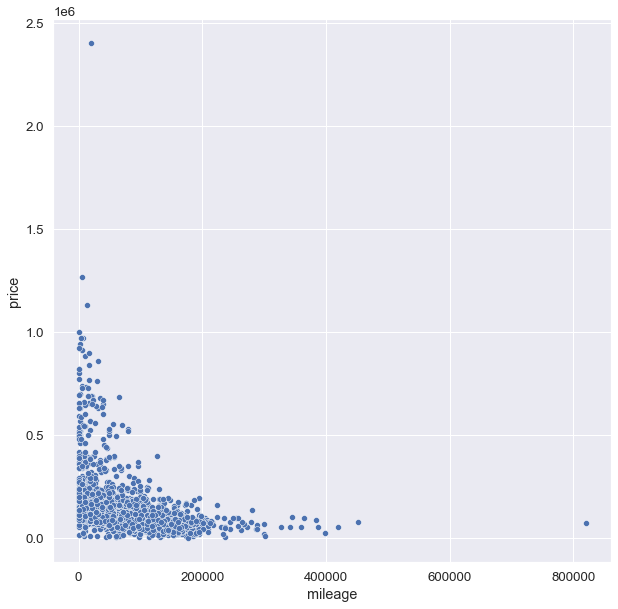

In [9]:
# plotting a scatterplot of Mileage vs Price
sns.set(rc={'figure.figsize':(10, 10)}, font_scale=1.2)
sns.scatterplot(data=data, x="mileage", y="price")

#### Qn: What are the brands should the startup aim to sell?

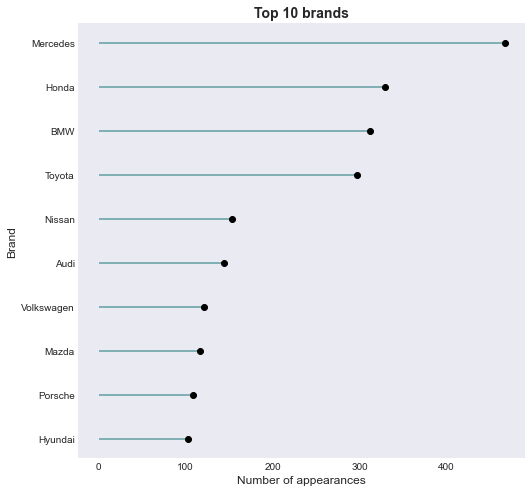

In [15]:
# Finding the brands to sell by determining the top 10 most popular brands

brands_ordered = data.groupby('brand').size().sort_values(ascending = False).reset_index(name = 'count')
top_10 = brands_ordered.loc[0:9, :]
top_10 = top_10.sort_values(by = 'count')

my_range = range(1, 11) # 11 because there are 10 items that are going to be plotted for top_10 

# Plotting top 10
plt.style.use('seaborn-dark')
plt.figure(figsize = (8, 8))
plt.hlines(y = my_range, xmin = 0, xmax = top_10['count'], color = '#5F9EA0')
plt.plot(top_10['count'], my_range, "o", color = 'black') 

plt.yticks(my_range, top_10['brand'])
plt.title("Top 10 brands", loc = 'center', fontweight = 'bold', fontsize = 14)
plt.xlabel('Number of appearances', fontsize = 12)
plt.ylabel('Brand', fontsize = 12)

plt.show()

#### Qn: Where should the startup open their dealership if they choose to do so? 

In [32]:
# importing the dealer location data
locations = pd.read_csv('dealer_loc.csv')
locations

,dealer,lat,long
0,motorist.sg,1.33710,103.89066
1,carro,1.30041,103.84179
2,carbuyer,1.29569,103.78750
3,gowheeler,1.43100,103.75486
4,sdas,1.33407,103.89932
5,sgcarmart,1.33154,103.90000
6,vincar,1.33207,103.90113
7,platinum,1.33312,103.89445
8,oneshift,1.28933,103.81278
9,ucars,1.29569,103.78750


In [33]:
# creating a map 
maps = folium.Map(location=[locations.lat.mean(), locations.long.mean()], zoom_start=12, control_scale=True)


In [34]:
# Adding the dealers on the map
for index, location_info in locations.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]], popup=location_info["dealer"]).add_to(maps)

In [35]:
# printing out the final map
maps